In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk

from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
from skimage import transform as sk
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import os
#from utils import load_input_image,getCAM
#import SaveFeatures as sf
import warnings
warnings.filterwarnings("ignore")

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [0]:
def is_grayscale(image):

    trans = transforms.ToTensor()
    if trans(image).shape[0] == 1:
        return True
    else:
        return False

def load_input_image(img_path):
    image = Image.open(Path(img_path))
    image_transform= transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    if is_grayscale(image) == True:
      print(" is a GreyScale Image")
      image = image.convert('RGB')

    image = image_transform(image)
    return image


In [0]:
display_transform = transforms.Compose([
   transforms.Resize((512,379))])

In [0]:
vgg = models.vgg16(pretrained=True)
checkpoint_vgg=torch.load('/content/drive/My Drive/Thesis/Finger/vgg_Finger_905.pth',map_location='cpu')

In [0]:
list(vgg.features[-3].parameters())[1].shape

torch.Size([512])

In [0]:
vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

In [0]:
vgg.load_state_dict(checkpoint_vgg,strict=False)

IncompatibleKeys(missing_keys=['classifier.6.weight', 'classifier.6.bias'], unexpected_keys=['classifier.6.1.weight', 'classifier.6.1.bias'])

In [0]:
sf = SaveFeatures(vgg.features[-3])

In [0]:
image= load_input_image("/content/drive/My Drive/image/test.png")
print(image.shape)
predict_val = Variable((image.unsqueeze(0)), requires_grad=True)
outputs = vgg(predict_val)

#classes [ant, bee]
res = torch.argmax(outputs.data).cpu().detach().numpy()
if res==1:
    print('result: abnormal',res)
else:
    print('result: normal',res)

torch.Size([3, 224, 224])
result: abnormal 1


In [0]:
pred_prob = F.softmax(outputs).data.squeeze()
sf.remove()
top=topk(pred_prob,1)

In [0]:
top=topk(pred_prob,1)
print("Probability predicted")
weight_softmax_params = list(vgg.features[-3].parameters())
weight_softmax = np.squeeze(weight_softmax_params[1].data.numpy())
class_idx = topk(pred_prob,1)[1].int()

Probability predicted


In [0]:
sf.features.shape

(1, 512, 14, 14)

In [0]:
weight_softmax_params[0].shape

torch.Size([512, 512, 3, 3])

In [0]:
f2=np.dot(np.rollaxis(fts_np,0,3), weight_softmax[class_idx])

ValueError: ignored

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
    print(feature_conv.shape)
   # print(weight_fc[class_idx])
    _, nc, h, w = feature_conv.shape
    print("here")
    #cam = (weight_fc[class_idx]).dot(feature_conv.reshape((nc, h*w)))
    cam=np.dot(weight_fc[class_idx],feature_conv.reshape((nc, h*w)))
    print("here2")
    print("h:",h,"w:",w)
    print(cam.shape)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (h, w))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0
    original_img = Image.open("/content/drive/My Drive/image/test.png")
    output_path="/content/drive/My Drive/image/"
   # print(original_img.shape)
    im_pil = Image.fromarray(heatmap)
    heatmap= display_transform(im_pil)
    heatmap = np. array(heatmap)
    img = heatmap*0.5 + original_img
    #img.save("/content/drive/My Drive/image/test_res.png")
   # cv2.imwrite(output_path, img)
    print(img.shape)
    image = Image.fromarray(img, 'RGB')
    image.save('/content/drive/My Drive/image/my.png')
    image.show()

In [0]:
overlay = getCAM(sf.features, weight_softmax, class_idx )

(1, 512, 14, 14)
here
here2
h: 14 w: 14
(512, 196)
(512, 379, 3)


In [0]:
dir_image_path="/content/drive/My Drive/"
image_name="test"
filename="test"
img=Image.open("/content/drive/My Drive/image/test.png")
xray_path = os.path.join(dir_image_path,'xray.png')
heatmap_path = os.path.join(dir_image_path,'heatmap.png')
plt.imsave(xray_path,display_transform(img))
plt.imsave(heatmap_path,sk.resize(overlay[0], image.shape[1:3]), cmap='jet')
print("CAM generated and saved")
xray_image = Image.open(xray_path)
heatmap_image = Image.open(heatmap_path)
result_img = Image.blend(heatmap_image, xray_image, 0.7)

# saves image in the project folder
result_filename=image_name+'_result.png'
result_img.save(os.path.join(dir_image_path,result_filename),"PNG")
result_path=os.path.join(dir_image_path,result_filename)

ori_image = Image.open(os.path.join(dir_image_path,filename))
ori_image= display_transform(ori_image)
ori_image.save(os.path.join(dir_image_path,filename))
print(result_img.size)

CAM generated and saved
(224, 224)


In [0]:
output = model.output[:, argmax]

In [0]:
last_conv_layer = model.get_layer('block5_conv3')

In [0]:

grads = K.gradients(output, last_conv_layer.output)[0]

In [0]:

pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [0]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [0]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

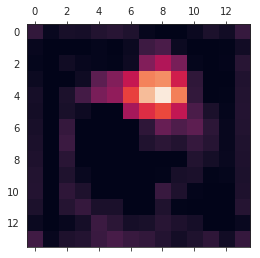

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:

import cv2
img = cv2.imread(img_path)

In [0]:

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [0]:
heatmap = np.uint8(255 * heatmap)

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [0]:
hif = .8

superimposed_img = heatmap * hif + img

Text(0.5, 1.0, 'iPod')

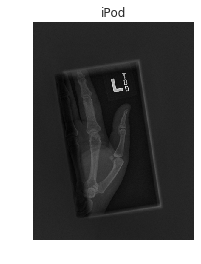

In [0]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

In [0]:
def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = '/content/drive/My Drive/image/1/elbow.png'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

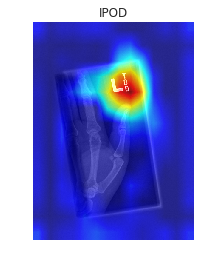

In [0]:
cam('/content/drive/My Drive/Thesis/Finger/test/0/23.png')